In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/tiny-imagenet-2020.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: tiny-imagenet-200/val/class_071/00026.jpg  
  inflating: tiny-imagenet-200/val/class_071/00008.jpg  
   creating: tiny-imagenet-200/val/class_198/
  inflating: tiny-imagenet-200/val/class_198/00004.jpg  
  inflating: tiny-imagenet-200/val/class_198/00043.jpg  
  inflating: tiny-imagenet-200/val/class_198/00027.jpg  
  inflating: tiny-imagenet-200/val/class_198/00017.jpg  
  inflating: tiny-imagenet-200/val/class_198/00025.jpg  
  inflating: tiny-imagenet-200/val/class_198/00002.jpg  
  inflating: tiny-imagenet-200/val/class_198/00001.jpg  
  inflating: tiny-imagenet-200/val/class_198/00006.jpg  
  inflating: tiny-imagenet-200/val/class_198/00015.jpg  
  inflating: tiny-imagenet-200/val/class_198/00048.jpg  
  inflating: tiny-imagenet-200/val/class_198/00041.jpg  
  inflating: tiny-imagenet-200/val/class_198/00022.jpg  
  inflating: tiny-imagenet-200/val/class_198/00000.jpg  
  inflating: tiny-imagenet-200/

In [3]:
import os
import matplotlib.pyplot as plt
import skimage
import re
import numpy as np
import cv2
from skimage import io
from IPython.display import clear_output

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [4]:
def read_files(path):
    X = []
    Y = []
    labels = os.listdir(path)
    for label in labels:
        for file in os.listdir(path+'/'+label):
            image=cv2.imread(path+label+'/'+file)
            X.append(image)
            new_label = int(re.sub("\D","", label))
            Y.append(new_label)
    return X,Y

In [5]:
train_x, train_y = read_files("/content/tiny-imagenet-200/train/")
test_x, test_y = read_files("/content/tiny-imagenet-200/val/")

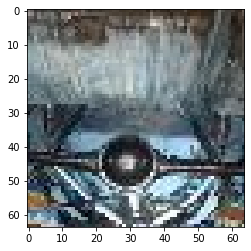

In [6]:
image = skimage.img_as_ubyte(train_x[0])
plt.imshow(image)

In [7]:
class TinyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.X = x
        self.Y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        img = skimage.img_as_ubyte(self.X[index])
        if self.transform:
            img = self.transform(img)
        return img, self.Y[index]

In [8]:
transform_img = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Resize((224,224))
])

In [9]:
train_dataset = TinyDataset(train_x, train_y, transform_img)
test_dataset = TinyDataset(test_x, test_y, transform_img)

train_loader = DataLoader(dataset=train_dataset, batch_size=512, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=True, drop_last=True)

In [10]:
for x, y in train_loader:
    print(x.shape,y.shape)
    break

torch.Size([512, 3, 224, 224]) torch.Size([512])


In [11]:
model = models.resnet18(pretrained=True)
_ = model.cuda()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [12]:
criterion = torch.nn.CrossEntropyLoss()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr)
num_epochs = 25

In [13]:
train_losses = []
val_losses = []

train_metrics = []
val_metrics = []

hist = {"train_loss": [],
        "train_accuracy": [],
        "test_loss": [],
        "test_accuracy": []}

Epoch 24/25	 Loss mean: 0.000949	 Accuracy mean: 0.999780
Epoch 24/25	 Val Loss mean: 2.046377	 Test Accuracy mean: 0.626202


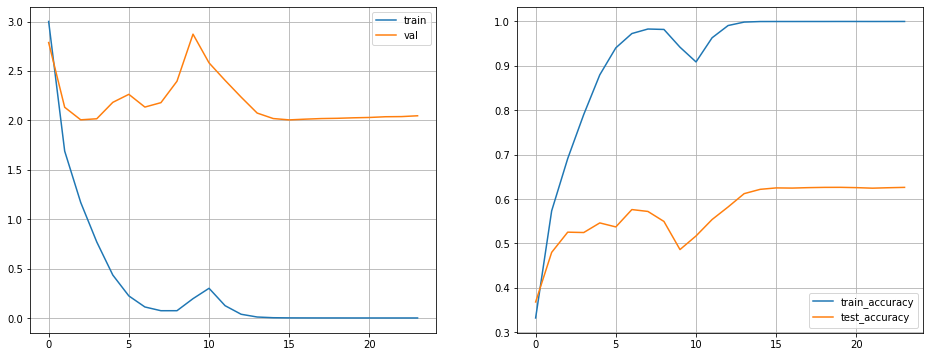

Epoch: 25 	Loss: 0.000207
Epoch: 25 	Loss: 0.001943
Epoch: 25 	Loss: 0.000212
Epoch: 25 	Loss: 0.002254
Epoch: 25 	Loss: 0.000168
Epoch: 25 	Loss: 0.000212
Epoch: 25 	Loss: 0.000172
Epoch: 25 	Loss: 0.000171
Epoch: 25 	Loss: 0.000182
Epoch: 25 	Loss: 0.000221
Epoch: 25 	Loss: 0.000180
Epoch: 25 	Loss: 0.000187
Epoch: 25 	Loss: 0.007235
Epoch: 25 	Loss: 0.000170
Epoch: 25 	Loss: 0.000197
Epoch: 25 	Loss: 0.000169
Epoch: 25 	Loss: 0.006005
Epoch: 25 	Loss: 0.000190
Epoch: 25 	Loss: 0.000180
Epoch: 25 	Loss: 0.000176


In [14]:
for i in range(num_epochs):
    if i > 0:
        print("Epoch %d/%d\t Loss mean: %f\t Accuracy mean: %f"% \
                (i, num_epochs, epoch_loss, epoch_accuracy))
        print("Epoch %d/%d\t Val Loss mean: %f\t Test Accuracy mean: %f"% \
            (i, num_epochs, test_loss, test_accuracy))

        plt.figure(figsize=(16, 6))
        plt.subplot(121)
        plt.plot(hist['train_loss'], label='train')
        plt.plot(hist['test_loss'], label='val')
        plt.legend()
        plt.grid()

        plt.subplot(122)
        plt.plot(hist['train_accuracy'], label='train_accuracy')
        plt.plot(hist['test_accuracy'], label='test_accuracy')
        plt.legend()
        plt.grid()
        plt.show()


    epoch_losses = []
    test_losses = []
    epoch_accuracies = []
    test_accuracies = []

    model.train()
    for k, (X, Y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(X.cuda())
        loss = criterion(y_pred, Y.cuda())
        accuracy = (torch.argmax(y_pred.detach().cpu(), 1) == Y.cpu()).sum()/len(Y)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accuracies.append(accuracy)
        if k%10 == 0:
            print("Epoch: %d \tLoss: %f"%(i+1, loss.item()))

    epoch_loss = np.mean(np.array(epoch_losses))
    epoch_accuracy = np.mean(np.array(epoch_accuracies))
    hist['train_accuracy'].append(epoch_accuracy)
    hist['train_loss'].append(epoch_loss)

    with torch.no_grad():
        model.eval()
        for k, (X, Y) in enumerate(test_loader):
            y_pred = model(X.cuda())
            loss = criterion(y_pred, Y.cuda())
            accuracy = (torch.argmax(y_pred.detach().cpu(), 1) == Y.cpu()).sum()/len(Y)
            test_losses.append(loss.item())
            test_accuracies.append(accuracy)

    test_loss = np.mean(np.array(test_losses))
    test_accuracy = np.mean(np.array(test_accuracies))
    hist['test_loss'].append(test_loss)
    hist['test_accuracy'].append(test_accuracy)
    
    if i < (num_epochs - 1):
        clear_output()